In [1]:
# Importation des librairies
import sys
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator
import random as rdm

In [ ]:
# Extraction des fichiers de données
!unzip test.zip -d /content/input
!unzip train.zip -d /content/input

In [2]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

## Chargement des données
On crée une fonction "load_data" pour charger les images et les labels correspondants à partir des dossiers de données.

In [3]:
def load_data():
    """
        Chargement des données:
            - 14,034 images pour entrainer notre réseau.
            - 3,000 images pour évaluer comment notre réseau a été entraîné.
    """
    
    datasets = ['./input/seg_train', './input/seg_test']
    output = []
    
    # Itération du dataset à travers les jeux de données train et test
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Itération à travers chaque dossier qui correspond à chaque catégorie
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Itération à travers chaque image dans le dossier
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Récupération du nom du chemin de l'image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Ouverture et redimensionnement de l'image
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Ajout de l'image et de son label correspondant à notre output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading ./input/seg_train


100%|██████████| 2382/2382 [00:06<00:00, 385.31it/s]


Loading ./input/seg_test


100%|██████████| 501/501 [00:01<00:00, 393.10it/s]


In [5]:
# Mélange des données 
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

## Exploration du dataset

In [8]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Nombre d'exemples de training: {}".format(n_train))
print ("Nombre d'exemples de test: {}".format(n_test))
print ("Chaque image est de taille: {}".format(IMAGE_SIZE))

Nombre d'exemples de training: 14034
Nombre d'exemples de test: 3000
Chaque image est de taille: (150, 150)


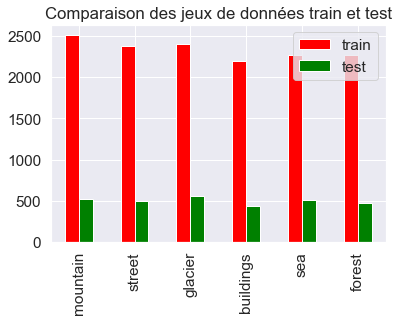

In [9]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar(color=['red', 'green'])
plt.title("Comparaison des jeux de données train et test")
plt.show()

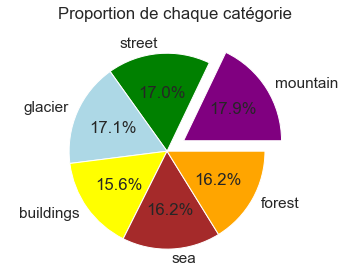

In [10]:
plt.pie(train_counts,
        explode=(0.2, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%',
        colors=['purple', 'green','lightblue','yellow','brown','orange'])
plt.axis('equal')
plt.title('Proportion de chaque catégorie\n')
plt.show()

On va mettre à l'échelle nos données pour ne pas avoir des problèmes dans la tailles des images.

In [6]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

On affiche les 25 premières images de notre jeu de données train avec leurs labels correspondants.

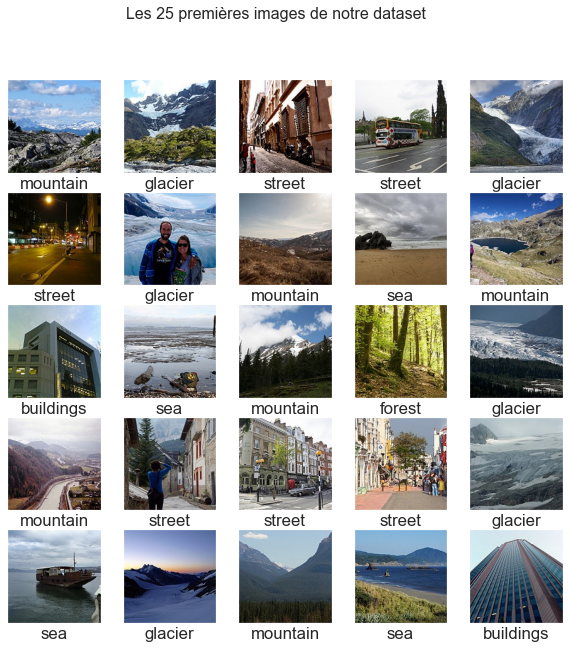

In [12]:
#Affichage des 25 premières images de notre jeu de données train avec leurs labels correspondants
def display_examples(class_names, images, labels):
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Les 25 premières images de notre dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()
display_examples(class_names, train_images, train_labels)

## Première partie: Création d'un premier modèle.

In [7]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv1D

In [8]:
model1 = Sequential()
model1.add(Conv2D(32, (3, 3), activation = 'sigmoid', input_shape = (150, 150, 3))), 
model1.add(MaxPooling2D(2,2)),
model1.add(Conv2D(32, (3, 3), activation = 'sigmoid')),
model1.add(MaxPooling2D(2,2)),
model1.add(Flatten()),
model1.add(Dense(120, activation='sigmoid', kernel_initializer='he_uniform')),
model1.add(Dense(32, activation='softmax')),
model1.add(Dense(6, activation=tf.nn.softmax))

In [9]:
model1.compile(optimizer = 'adam', loss = 'mse', metrics=['accuracy'])

In [46]:
model1.fit(train_images, train_labels, batch_size=110, epochs=15, validation_split = 0.2)

Epoch 1/15
103/103 [==============================] - 146s 1s/step - loss: 8.1155 - accuracy: 0.1697 - val_loss: 8.1043 - val_accuracy: 0.1710
Epoch 2/15
103/103 [==============================] - 146s 1s/step - loss: 8.1155 - accuracy: 0.1659 - val_loss: 8.1043 - val_accuracy: 0.1746
Epoch 3/15
103/103 [==============================] - 143s 1s/step - loss: 8.1155 - accuracy: 0.1674 - val_loss: 8.1043 - val_accuracy: 0.1710
Epoch 4/15
103/103 [==============================] - 147s 1s/step - loss: 8.1155 - accuracy: 0.1668 - val_loss: 8.1043 - val_accuracy: 0.1589
Epoch 5/15
103/103 [==============================] - 147s 1s/step - loss: 8.1155 - accuracy: 0.1669 - val_loss: 8.1043 - val_accuracy: 0.1710
Epoch 6/15
103/103 [==============================] - 133s 1s/step - loss: 8.1155 - accuracy: 0.1648 - val_loss: 8.1043 - val_accuracy: 0.1589
Epoch 7/15
103/103 [==============================] - 129s 1s/step - loss: 8.1155 - accuracy: 0.1707 - val_loss: 8.1043 - val_accuracy: 0.1710

## Deuxième partie: Création d'un deuxième modèle en essayant d'améliorer nos résultats.

In [10]:
model2 = Sequential()
model2.add(Conv2D(180, (3,3), activation = 'relu', input_shape = (150, 150, 3))), 
model2.add(MaxPooling2D(2,2)),
model2.add(Conv2D(64, (3,3), activation = 'relu')),
model2.add(MaxPooling2D(4,4)),
model2.add(Flatten()),
model2.add(Dense(280, activation='relu', kernel_initializer='he_uniform')),
model2.add(Dense(32, activation='softplus')),
model2.add(Dense(6, activation=tf.nn.softplus))

In [11]:
model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [67]:
model2.fit(train_images, train_labels, batch_size=100, epochs=15, validation_split = 0.2)

Epoch 1/15
113/113 [==============================] - 753s 7s/step - loss: 1.4104 - accuracy: 0.2186 - val_loss: 1.2439 - val_accuracy: 0.2480
Epoch 2/15
113/113 [==============================] - 734s 6s/step - loss: 1.1678 - accuracy: 0.2605 - val_loss: 1.1004 - val_accuracy: 0.3114
Epoch 3/15
113/113 [==============================] - 693s 6s/step - loss: 1.0249 - accuracy: 0.2709 - val_loss: 1.0392 - val_accuracy: 0.3128
Epoch 4/15
113/113 [==============================] - 651s 6s/step - loss: 0.9376 - accuracy: 0.2945 - val_loss: 1.0183 - val_accuracy: 0.2775
Epoch 5/15
113/113 [==============================] - 648s 6s/step - loss: 0.8882 - accuracy: 0.3375 - val_loss: 1.0712 - val_accuracy: 0.3028
Epoch 6/15
113/113 [==============================] - 644s 6s/step - loss: 0.8436 - accuracy: 0.3363 - val_loss: 1.0846 - val_accuracy: 0.2921
Epoch 7/15
113/113 [==============================] - 719s 6s/step - loss: 0.7978 - accuracy: 0.3303 - val_loss: 1.0585 - val_accuracy: 0.2223

## Troisième partie: Création de notre modèle final.
On suit l'ordre suivant: 

1.   On consruit le modèle
2.   On compile le modèle
3.   On entraîne le modèle avec la fonction "fit"
4.   On évalue le modèle avec le jeu de données test à l'aide de la fonction "evaluate"
5.   On analyse si notre modèle présente une erreur

Notre premier modèle simple se compose des couches suivantes:


*   Conv2D(32,(3,3)): Des couches de convolution 2D parce que notre modèle traite des données de format images.
*   (MaxPooling2D(2,2)): Des couches MaxPooling 2D qui réduit les images de moitié.
*   Flatten(): Transforme le format des images d'un tableau 2D vers un tableau 1D de 150x150.
*   Relu: pour une valeur de x, la fonction relu renvoie: max(x, 0)
*   Dernière couche: Dense() avec paramètre une fonction d'activation 'softmax': 6 neurones, probabilité que l'image appartienne à l'une des 6 catégories (buildings, forest, glacier, moutain, sea, street).


In [12]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3))), 
model.add(MaxPooling2D(2,2)),
model.add(Conv2D(32, (3, 3), activation = 'relu')),
model.add(MaxPooling2D(2,2)),
model.add(Flatten()),
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform')),
model.add(Dense(32, activation='softmax')),
model.add(Dense(6, activation=tf.nn.softmax))

*   Fonction Loss, 'sparse_categorical_cross_entropy': nous utilisons cette fonction loss pour la classification, chaque image appartient à une seule catégorie uniquement.

In [13]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [25]:
model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
88/88 [==============================] - 239s 3s/step - loss: 1.6457 - accuracy: 0.3203 - val_loss: 1.5903 - val_accuracy: 0.3687
Epoch 2/20
88/88 [==============================] - 143s 2s/step - loss: 1.5567 - accuracy: 0.3826 - val_loss: 1.5328 - val_accuracy: 0.4364
Epoch 3/20
88/88 [==============================] - 137s 2s/step - loss: 1.4921 - accuracy: 0.4086 - val_loss: 1.4534 - val_accuracy: 0.4325
Epoch 4/20
88/88 [==============================] - 134s 2s/step - loss: 1.4217 - accuracy: 0.4497 - val_loss: 1.3757 - val_accuracy: 0.5183
Epoch 5/20
88/88 [==============================] - 136s 2s/step - loss: 1.3380 - accuracy: 0.5612 - val_loss: 1.3052 - val_accuracy: 0.5718
Epoch 6/20
88/88 [==============================] - 133s 2s/step - loss: 1.2478 - accuracy: 0.6028 - val_loss: 1.2389 - val_accuracy: 0.5921
Epoch 7/20
88/88 [==============================] - 154s 2s/step - loss: 1.1571 - accuracy: 0.6451 - val_loss: 1.1843 - val_accuracy: 0.6145
Epoch 8/20
88

* On va maintenant tester notre modèle pour essayer de voir s'il est capable de renvoyer le nom de la bonne catégorie que l'image qu'on lui donne aléatoirement.

In [14]:
# On créer une fonction pour afficher une image aléatoire
def display_random_image(class_names, images, labels):
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

* On obtient 1 résultat correct au bout de la troisième tentative ! 

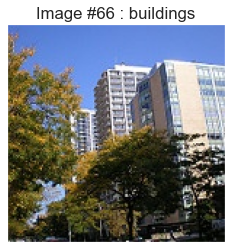

In [23]:
# Vecteur de probabilité
predictions = model.predict(test_images)
# On prend la plus haute probabilité
predicted_labels = np.argmax(predictions, axis = 1)

display_random_image(class_names, test_images, predicted_labels)

* Voici une description de notre modèle final:

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 41472)             0         
                                                                 
 dense_6 (Dense)             (None, 256)              

* On enregistre notre modèle dans le répertoire "./model"

In [17]:
model.save('./model')

INFO:tensorflow:Assets written to: ./model\assets


## Quatrième partie: Création d'un modèle avec la récupération d'un model déjà entraîné (Transfer-Learning).

In [15]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

transfer_model = VGG16(weights=None, include_top=False)

In [28]:
train_set = transfer_model.predict(train_images)
test_set = transfer_model.predict(test_images)

In [29]:
n_train, x, y, z = train_set.shape
n_test, x, y, z = test_set.shape
numFeatures = x * y * z

In [49]:
model_trained = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (x, y, z)),
    tf.keras.layers.Dense(5000, activation=tf.nn.relu, input_shape = (150, 150, 3)),
    tf.keras.layers.Dense(1000, activation=tf.nn.relu),
    tf.keras.layers.Dense(550, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model_trained.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history2 = model_trained.fit(train_set, train_labels, batch_size=128, epochs=15, validation_split = 0.2)

Epoch 1/15
88/88 [==============================] - 30s 337ms/step - loss: 1.6131 - accuracy: 0.2860 - val_loss: 1.5127 - val_accuracy: 0.3491
Epoch 2/15
88/88 [==============================] - 29s 333ms/step - loss: 1.3570 - accuracy: 0.4279 - val_loss: 1.2401 - val_accuracy: 0.4813
Epoch 3/15
88/88 [==============================] - 31s 350ms/step - loss: 1.2338 - accuracy: 0.4883 - val_loss: 1.2282 - val_accuracy: 0.4938
Epoch 4/15
88/88 [==============================] - 30s 344ms/step - loss: 1.1515 - accuracy: 0.5282 - val_loss: 1.0730 - val_accuracy: 0.5672
Epoch 5/15
88/88 [==============================] - 30s 343ms/step - loss: 1.0902 - accuracy: 0.5646 - val_loss: 1.1620 - val_accuracy: 0.5290
Epoch 6/15
88/88 [==============================] - 30s 337ms/step - loss: 1.0630 - accuracy: 0.5785 - val_loss: 0.9923 - val_accuracy: 0.6078
Epoch 7/15
88/88 [==============================] - 30s 338ms/step - loss: 1.0431 - accuracy: 0.5925 - val_loss: 1.1199 - val_accuracy: 0.5579

## Cinquième Partie: 
* On charge d'autres images personnelles pour pouvoir tester notre modèle avec nos propres images

In [16]:
def load_data_1():
    """
        Chargement des données:
            - 27 images pour entrainer notre réseau.
            - 16 images pour évaluer comment notre réseau a été entraîné.
    """
    
    datasets1 = ['./input2/seg_train', './input2/seg_test']
    output1 = []
    
    # Itération du dataset à travers les jeux de données train et test
    for dataset in datasets1:
        
        images1 = []
        labels1 = []
        
        print("Loading {}".format(dataset))
        
        # Itération à travers chaque dossier qui correspond à chaque catégorie
        for folder in os.listdir(dataset):
            label1 = class_names_label[folder]
            
            # Itération à travers chaque image dans le dossier
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Récupération du nom du chemin de l'image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Ouverture et redimensionnement de l'image
                image1 = cv2.imread(img_path)
                # image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
                # image1 = cv2.resize(image1, IMAGE_SIZE) 
                
                # Ajout de l'image et de son label correspondant à notre output
                images1.append(image1)
                labels1.append(label1)
                
        images1 = np.array(images1)
        labels1 = np.array(labels1)   
        
        output1.append((images1, labels1))

    return output1

In [17]:
(train_images2, train_labels2), (test_images2, test_labels2) = load_data_1()

Loading ./input2/seg_train


100%|██████████| 1/1 [00:00<00:00, 211.80it/s]
C:\Users\Hibatoullah\AppData\Local\Temp\ipykernel_7756\3745480644.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images1 = np.array(images1)


Loading ./input2/seg_test


100%|██████████| 5/5 [00:00<00:00, 74.91it/s]


In [23]:
test_images3 = np.asarray(test_images2).astype(np.int)

C:\Users\Hibatoullah\AppData\Local\Temp\ipykernel_21360\4276456070.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_images3 = np.asarray(test_images2).astype(np.int)


In [ ]:
# Vecteur de probabilité
predictions2 = model.predict(test_images2)
# On prend la plus haute probabilité
predicted_labels2 = np.argmax(predictions2, axis = 1)

display_random_image(class_names, test_images2, predicted_labels2)

# Autres développements:
* Nous avons testé une technique d'augmentation des données:

In [23]:
image_width, image_height = 150,150

train_images4 = ImageDataGenerator(
      rescale=1./255,
      rotation_range=90,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=False,
      fill_mode='nearest'
)

test_images4 = ImageDataGenerator( rescale = 1./255. )

train_images_generator = train_images4.flow_from_directory(
                    "./input/seg_train/",
                    batch_size=800,
                    class_mode='categorical',
                    target_size=(image_width, image_height)
)  

test_images_generator =  test_images4.flow_from_directory(
                    "./input/seg_test/",
                    batch_size=800, 
                    class_mode='categorical',
                    target_size=(image_width, image_height)
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


* ImageDataGenerator(), rotation_range: Affichage d'une image avec une technique d'augmentation de donnée, une rotation de l'image.

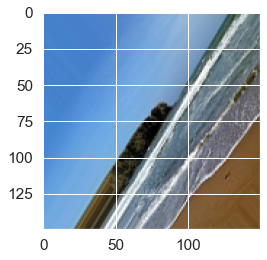

In [24]:
i = rdm.randint(0,800)    
batch=next(train_images_generator)  
img=batch[0][i]
plt.imshow(img)